In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import datashader as ds
from pyproj import Proj, transform
from datashader.utils import lnglat_to_meters as webm
from functools import partial 
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display
import datashader.transfer_functions as tf

In [2]:
df = pd.read_csv("/Users/morrow/Documents/Baumkataster_Visualisierung/Baum.csv", sep=";" , decimal=".")

df['Gattung'] = df['Gattung/Art/Deutscher Name'].str.split(',').str[0]
df['Deutscher Name'] = df['Gattung/Art/Deutscher Name'].str.split(',').str[1]
df['HOCHWERT'] = (df['HOCHWERT'].replace('\,','.', regex=True).astype(float))
df['RECHTSWERT'] = (df['RECHTSWERT'].replace('\,','.', regex=True).astype(float))
df['Kronendurchmesser'] = df['Kronendurchmesser'].replace('\,','.', regex=True).astype(float)
df.head()

Gattung/Art/Deutscher Name Baumnummer            Objekt  \
0  Platanus x hispanica, Gewoehnliche Platane          1  Ackermannstrasse   
1  Platanus x hispanica, Gewoehnliche Platane          2  Ackermannstrasse   
2  Platanus x hispanica, Gewoehnliche Platane          3  Ackermannstrasse   
3  Platanus x hispanica, Gewoehnliche Platane          4  Ackermannstrasse   
4  Platanus x hispanica, Gewoehnliche Platane          5  Ackermannstrasse   

   Pflanzjahr  Kronendurchmesser    HOCHWERT  RECHTSWERT  \
0        1920                8.0  5549510.90  473366.239   
1        1920                8.0  5549517.24  473363.459   
2        1920                8.0  5549524.39  473360.149   
3        1920                8.0  5549531.00  473357.239   
4        1920                8.0  5549537.75  473354.479   

                Gattung         Deutscher Name  
0  Platanus x hispanica   Gewoehnliche Platane  
1  Platanus x hispanica   Gewoehnliche Platane  
2  Platanus x hispanica   Gewoehnliche Platane  
3  Platanus x hispanica   Gewoehnliche Platane  
4  Platanus x hispanica   Gewoehnliche Platane

In [3]:
df.drop(columns=['Gattung/Art/Deutscher Name'])

Baumnummer                                Objekt  Pflanzjahr  \
0               1                      Ackermannstrasse        1920   
1               2                      Ackermannstrasse        1920   
2               3                      Ackermannstrasse        1920   
3               4                      Ackermannstrasse        1920   
4               5                      Ackermannstrasse        1920   
...           ...                                   ...         ...   
118398         84                      In den Seewiesen        1985   
118399         39  Kalbacher Hauptstrasse/Landesstrasse        2000   
118400         42  Kalbacher Hauptstrasse/Landesstrasse        1995   
118401       W 71  Kalbacher Hauptstrasse/Landesstrasse        1980   
118402       W 77  Kalbacher Hauptstrasse/Landesstrasse        1990   

        Kronendurchmesser    HOCHWERT  RECHTSWERT               Gattung  \
0                     8.0  5549510.90  473366.239  Platanus x hispanica   
1                     8.0  5549517.24  473363.459  Platanus x hispanica   
2                     8.0  5549524.39  473360.149  Platanus x hispanica   
3                     8.0  5549531.00  473357.239  Platanus x hispanica   
4                     8.0  5549537.75  473354.479  Platanus x hispanica   
...                   ...         ...         ...                   ...   
118398                6.0  5559292.96  474735.290        Betula pendula   
118399                3.0  5559565.38  474846.369        Acer campestre   
118400                6.0  5559555.49  474847.069     Prunus cerasifera   
118401                2.0  5559472.21  474893.130   waldartiger Bestand   
118402                2.0  5559376.02  474964.000   waldartiger Bestand   

               Deutscher Name  
0        Gewoehnliche Platane  
1        Gewoehnliche Platane  
2        Gewoehnliche Platane  
3        Gewoehnliche Platane  
4        Gewoehnliche Platane  
...                       ...  
118398           Haenge-Birke  
118399             Feld-Ahorn  
118400          Kirschpflaume  
118401                    NaN  
118402                    NaN  

[118403 rows x 8 columns]

In [4]:
#utm15_wgs84 = Proj(init='epsg:32632', proj='utm',zone=10,ellps='WGS84', preserve_units=False)
utm15_wgs84 = Proj(init='epsg:5243', proj='utm', zone='32N', ellps="GRS80")
df[['lon', 'lat']] = df.apply(lambda row:utm15_wgs84(row['RECHTSWERT'], row['HOCHWERT'], inverse=True), axis=1).apply(pd.Series)

In [5]:
y_range_min = df['lat'].quantile(0.01)
y_range_max = df['lat'].quantile(0.99)
x_range_min = df['lon'].quantile(0.01)
x_range_max = df['lon'].quantile(0.99)

In [6]:
df.head()
df.drop(columns=['Gattung/Art/Deutscher Name'])
df['Kronendurchmesser'].unique()
np.sort(df['Kronendurchmesser'])

array([ 2.,  2.,  2., ..., 33., 35., 63.])

In [7]:
bins = [0,2,4,6,10,15,20,30,50]
labels = ['mini', 'klein', 'klein_2', 'mittel', 'mittel_2', 'mittel_3', 'groß', 'groß_2']
df['diskret_kronendurchmesser'] = pd.cut(df.Kronendurchmesser, bins=bins, labels=labels)
df.drop(columns=['Gattung/Art/Deutscher Name'])

Baumnummer                                Objekt  Pflanzjahr  \
0               1                      Ackermannstrasse        1920   
1               2                      Ackermannstrasse        1920   
2               3                      Ackermannstrasse        1920   
3               4                      Ackermannstrasse        1920   
4               5                      Ackermannstrasse        1920   
...           ...                                   ...         ...   
118398         84                      In den Seewiesen        1985   
118399         39  Kalbacher Hauptstrasse/Landesstrasse        2000   
118400         42  Kalbacher Hauptstrasse/Landesstrasse        1995   
118401       W 71  Kalbacher Hauptstrasse/Landesstrasse        1980   
118402       W 77  Kalbacher Hauptstrasse/Landesstrasse        1990   

        Kronendurchmesser    HOCHWERT  RECHTSWERT               Gattung  \
0                     8.0  5549510.90  473366.239  Platanus x hispanica   
1                     8.0  5549517.24  473363.459  Platanus x hispanica   
2                     8.0  5549524.39  473360.149  Platanus x hispanica   
3                     8.0  5549531.00  473357.239  Platanus x hispanica   
4                     8.0  5549537.75  473354.479  Platanus x hispanica   
...                   ...         ...         ...                   ...   
118398                6.0  5559292.96  474735.290        Betula pendula   
118399                3.0  5559565.38  474846.369        Acer campestre   
118400                6.0  5559555.49  474847.069     Prunus cerasifera   
118401                2.0  5559472.21  474893.130   waldartiger Bestand   
118402                2.0  5559376.02  474964.000   waldartiger Bestand   

               Deutscher Name       lon        lat diskret_kronendurchmesser  
0        Gewoehnliche Platane  8.627616  50.097259                    mittel  
1        Gewoehnliche Platane  8.627577  50.097316                    mittel  
2        Gewoehnliche Platane  8.627530  50.097380                    mittel  
3        Gewoehnliche Platane  8.627489  50.097439                    mittel  
4        Gewoehnliche Platane  8.627450  50.097500                    mittel  
...                       ...       ...        ...                       ...  
118398           Haenge-Birke  8.646109  50.185295                   klein_2  
118399             Feld-Ahorn  8.647647  50.187750                     klein  
118400          Kirschpflaume  8.647657  50.187661                   klein_2  
118401                    NaN  8.648308  50.186914                      mini  
118402                    NaN  8.649307  50.186052                      mini  

[118403 rows x 11 columns]

In [8]:
# Alle Bäume, die nach 2000 gepflanzt wurden
df['Pflanzjahr'] = (df['Pflanzjahr'].astype(int))
new_df = df[df['Pflanzjahr'] >= 2000].copy()

In [9]:
sw = webm(x_range_min, y_range_min)
ne = webm(x_range_max, y_range_max)
FFM = zip(sw, ne)

In [10]:
# Initialize plot for datashader

plot_width = int(2000)
plot_height = int(2000)
background="black"
export = partial(export_image, background = background, export_path="export")
#cm = partial(colormap_select, reverse=(background!="black"))
cm = partial(colormap_select, reverse=(background!="black"))


display(HTML("<style>.container {width:100%} !important; }</style>"))

In [11]:
cvs = ds.Canvas(plot_width, plot_height, *FFM)
agg = cvs.points(df, 'RECHTSWERT', 'HOCHWERT')

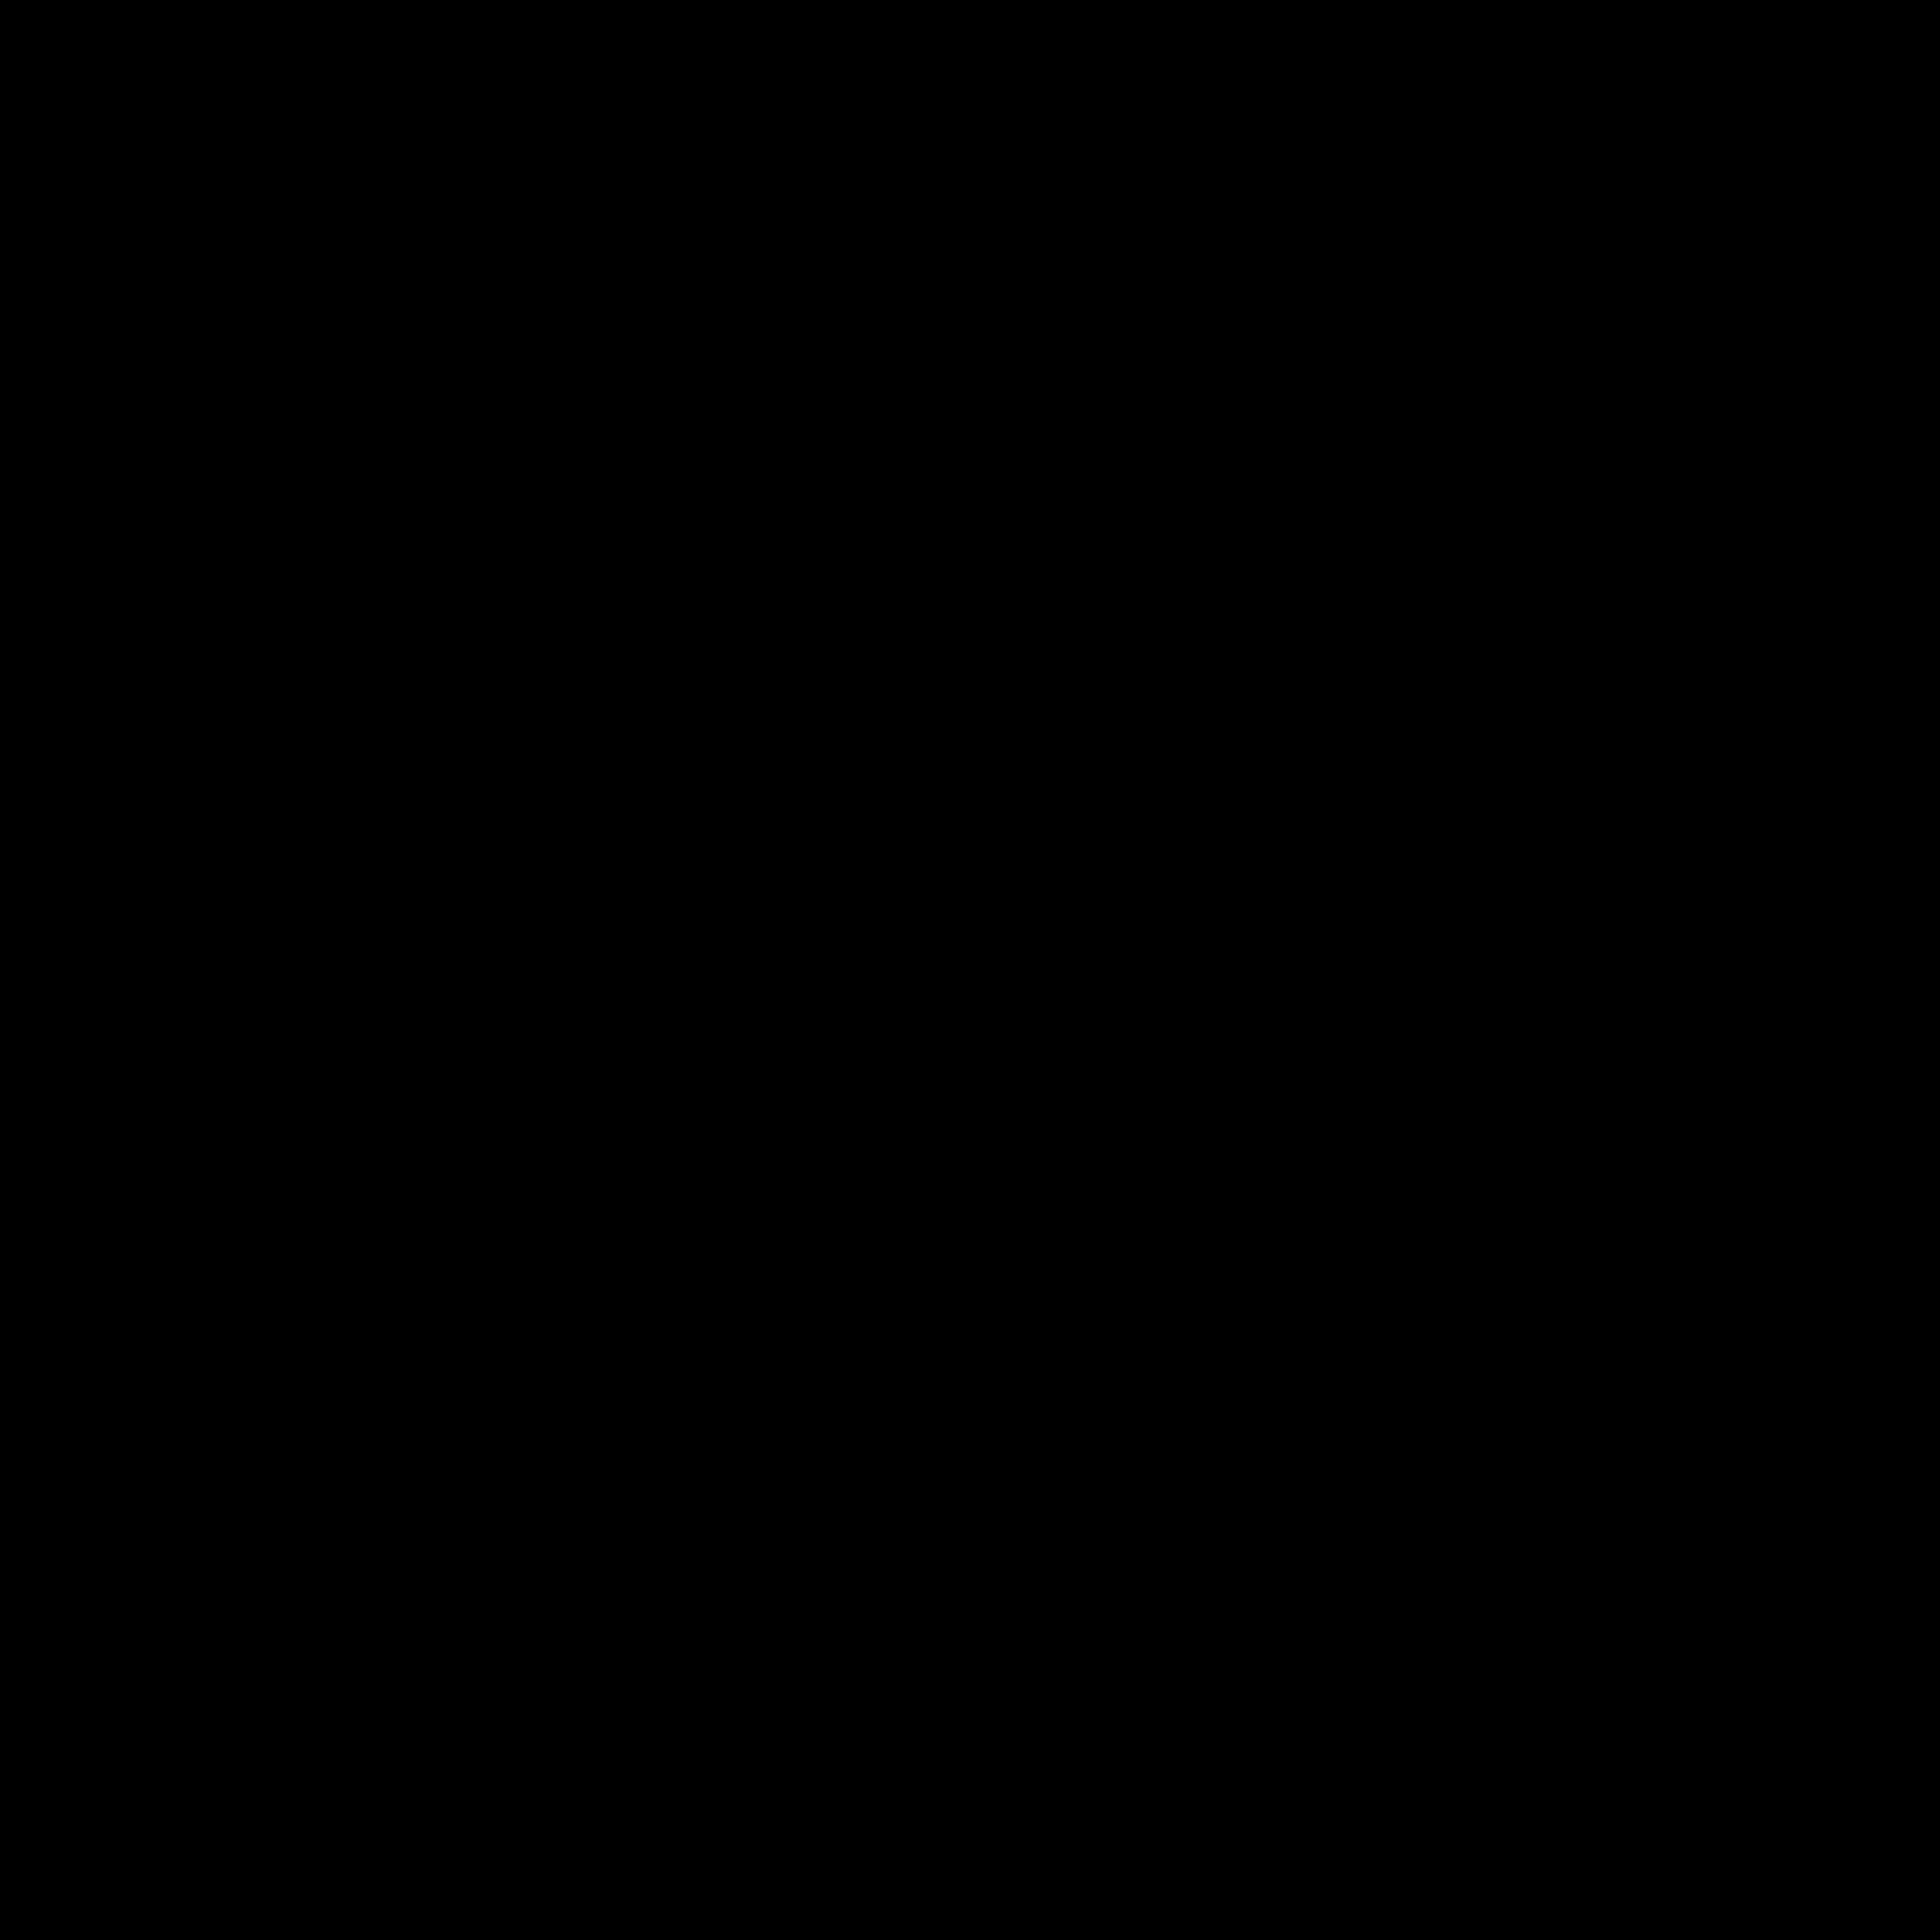

In [32]:
# Export image on different styles or conditions
export(tf.shade(agg, cmap = cm(Greys9,0.2), how='log'), "Frankfurt_Baumbestand")

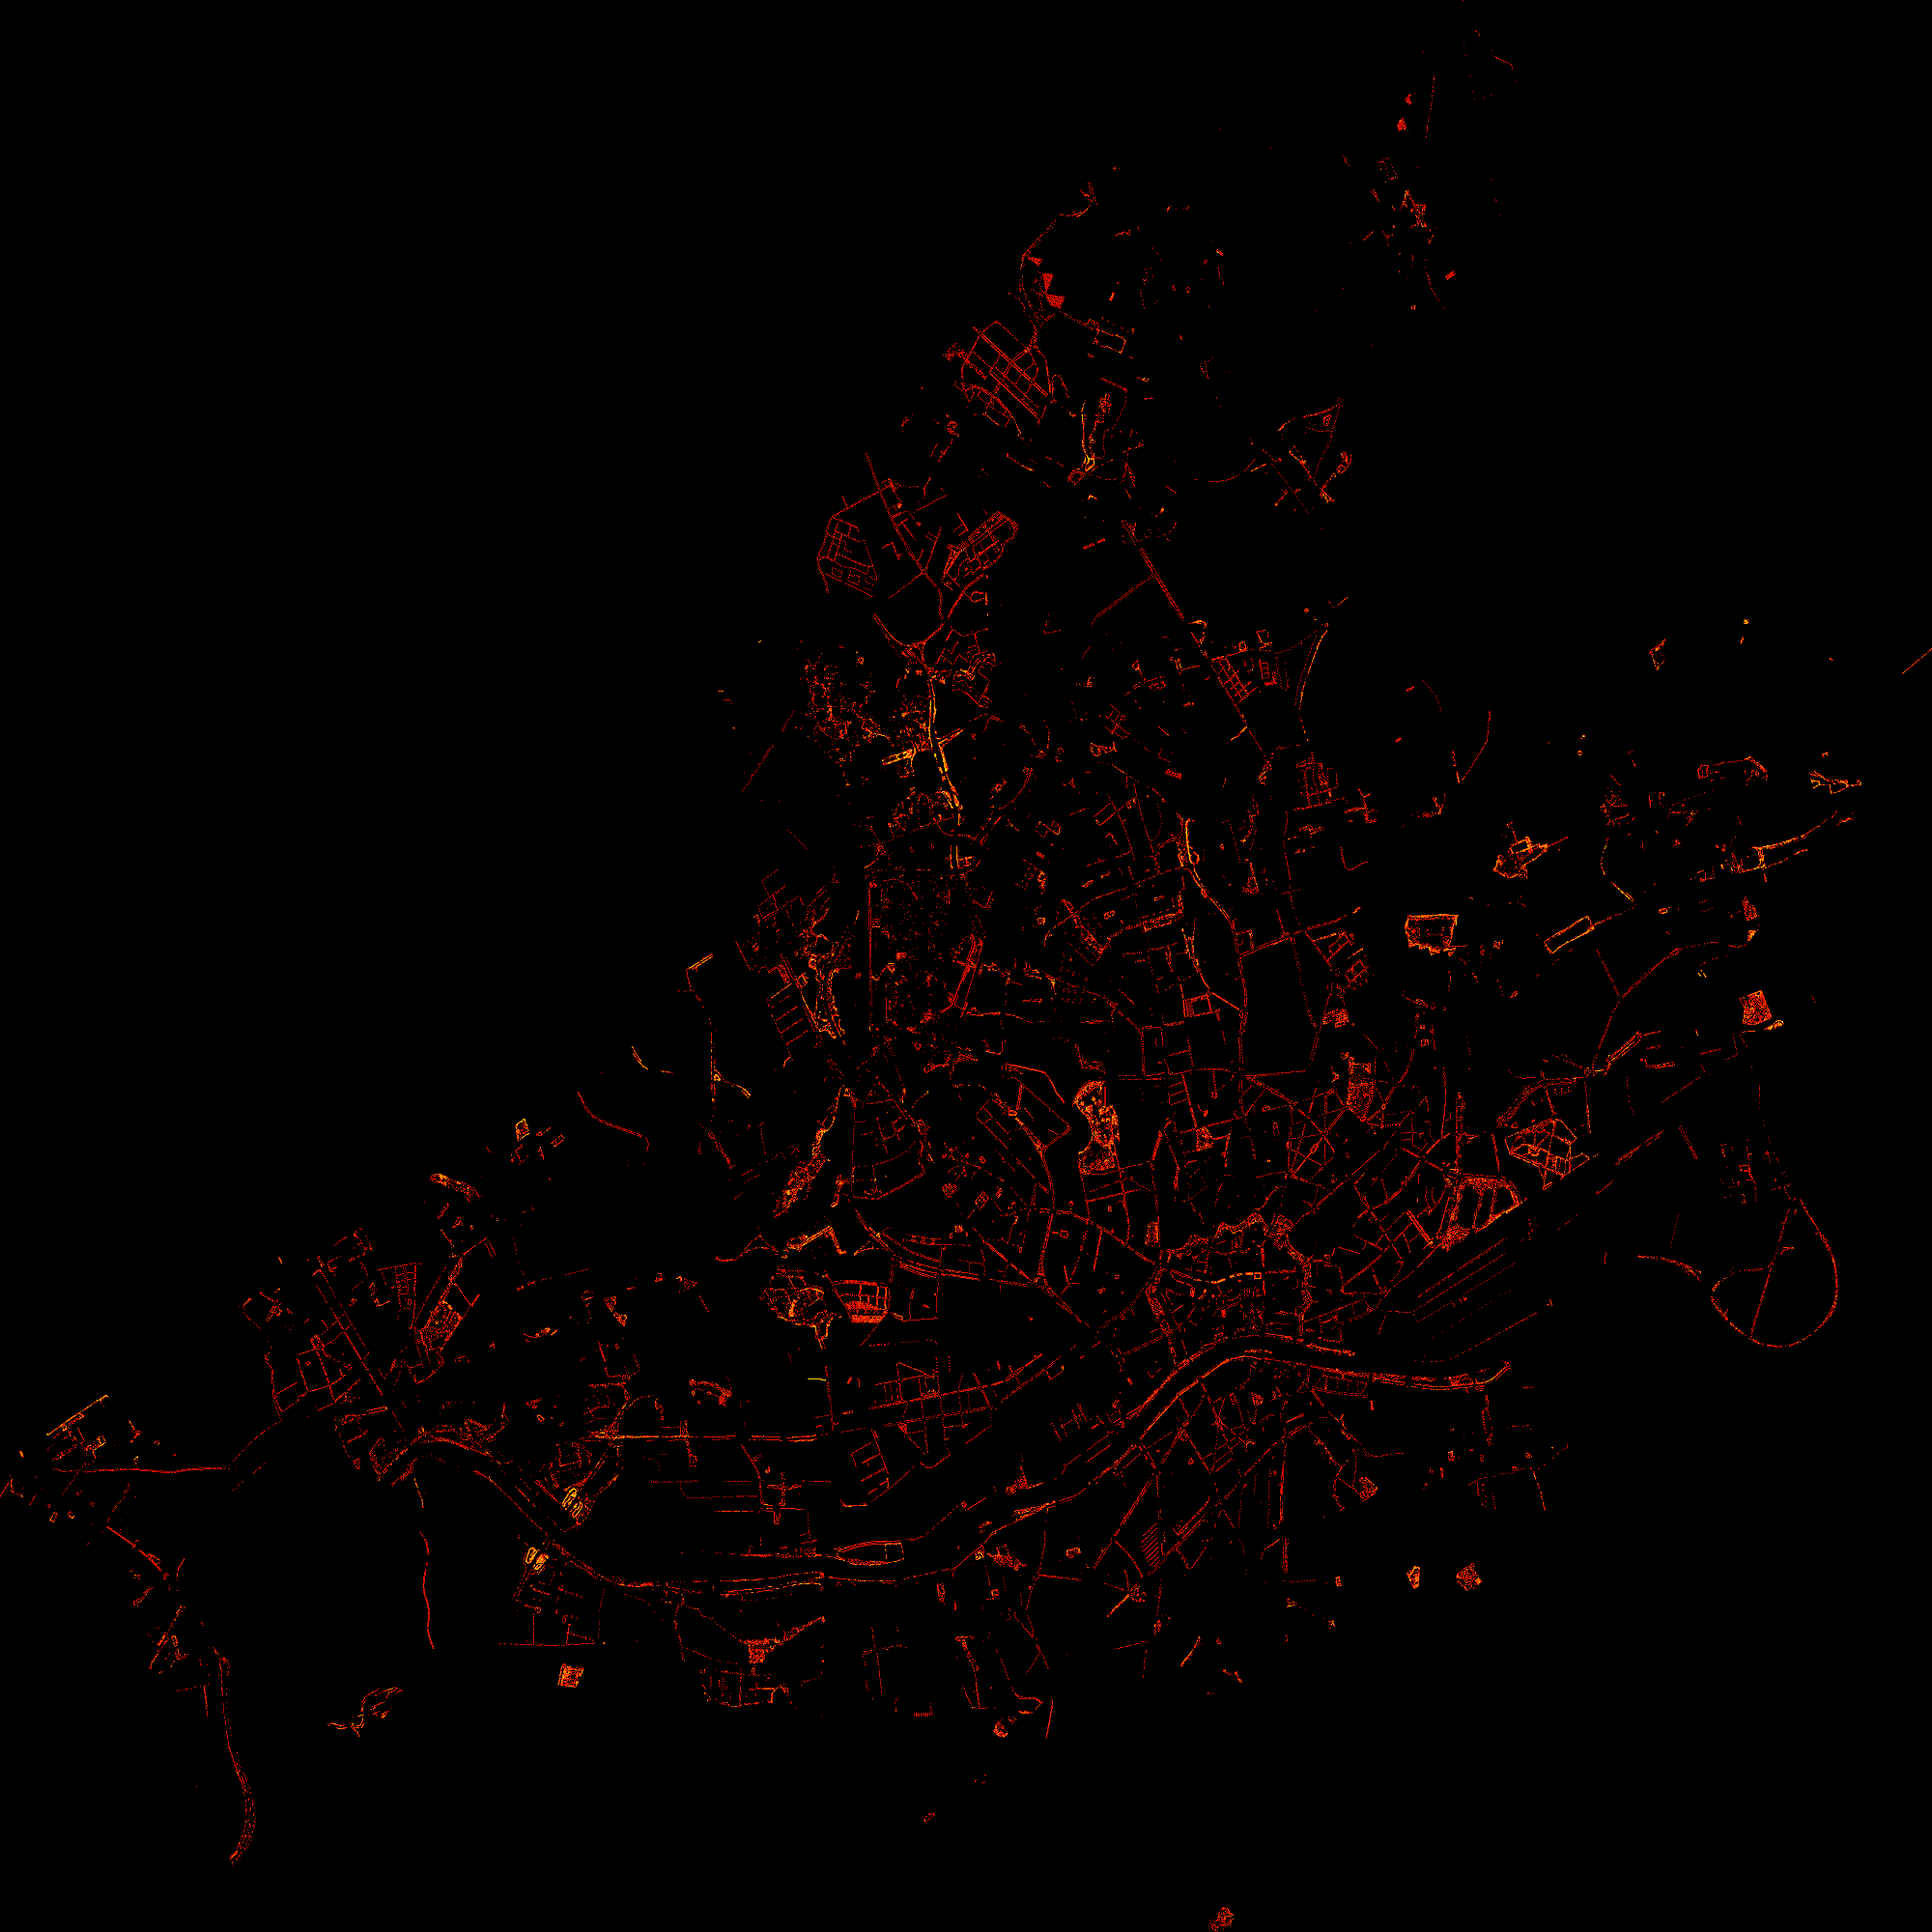

In [156]:
from colorcet import fire
export(tf.shade(agg, cmap = cm(fire,0.4), how='log'), "Frankfurt_Baumbestand_Fire")

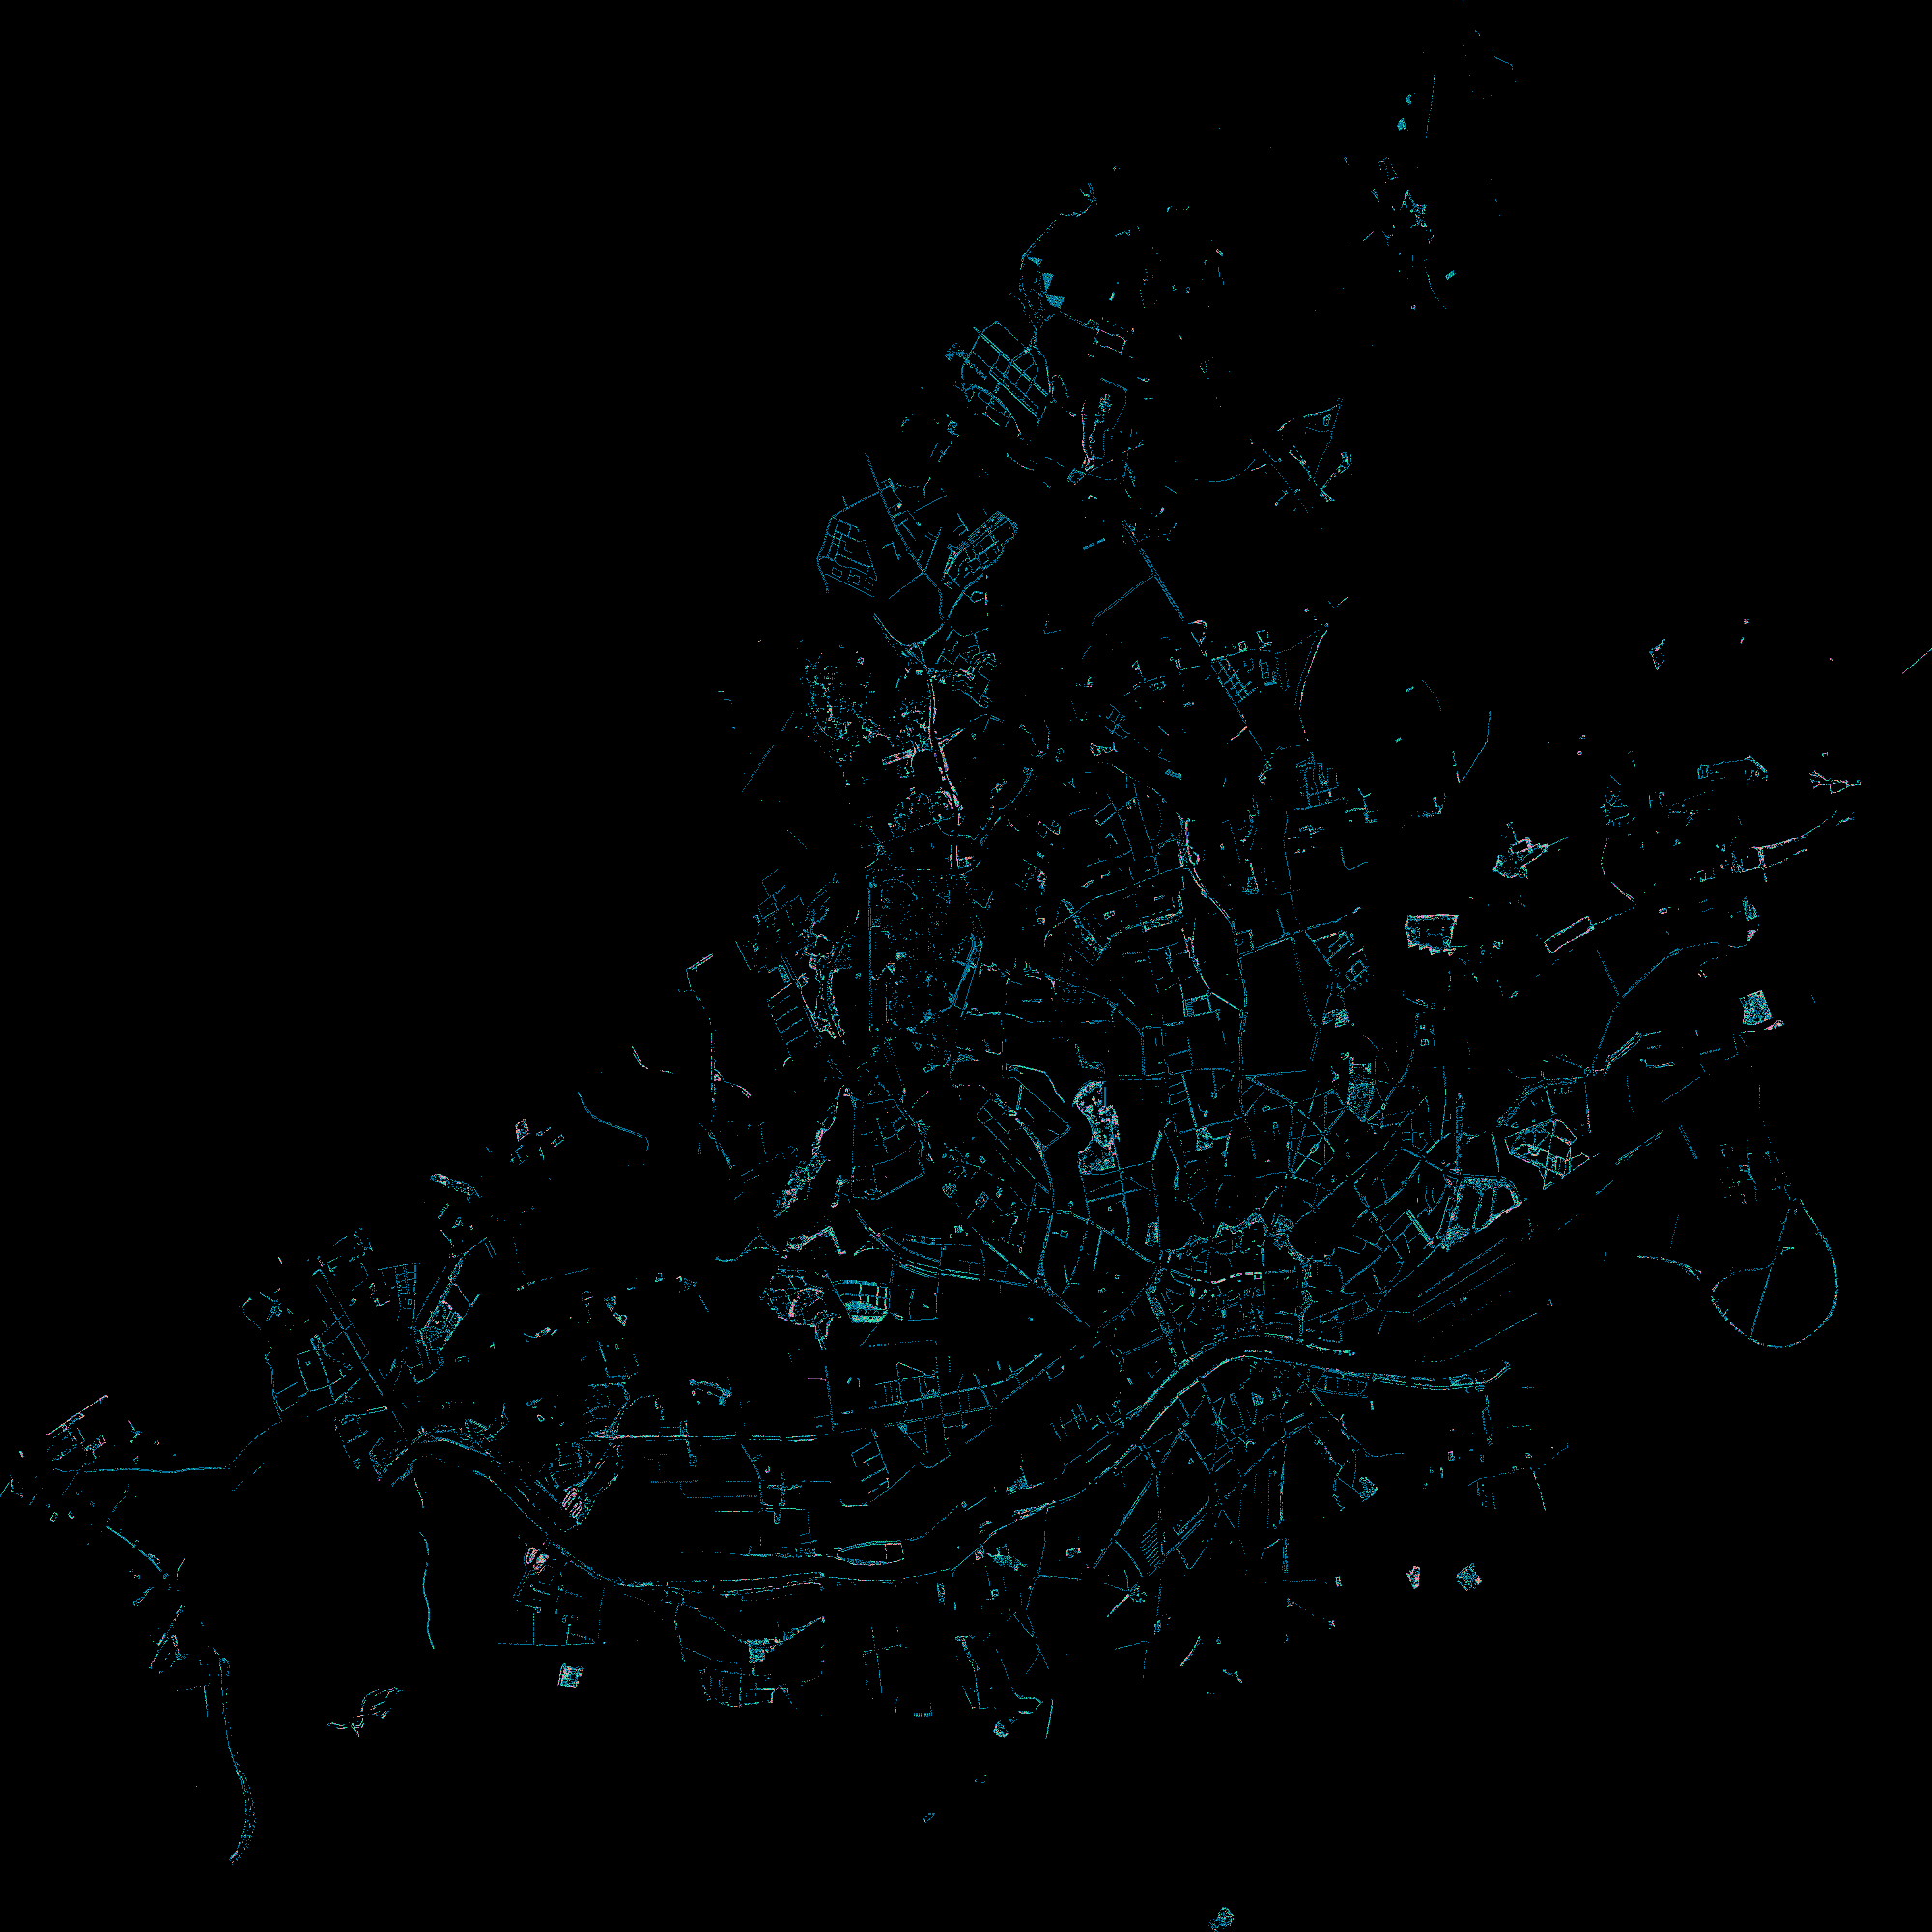

In [157]:
from colorcet import glasbey
export(tf.shade(agg, cmap = cm(glasbey,0.4), how='eq_hist'), "Frankfurt_Baumbestand_Glasbey")

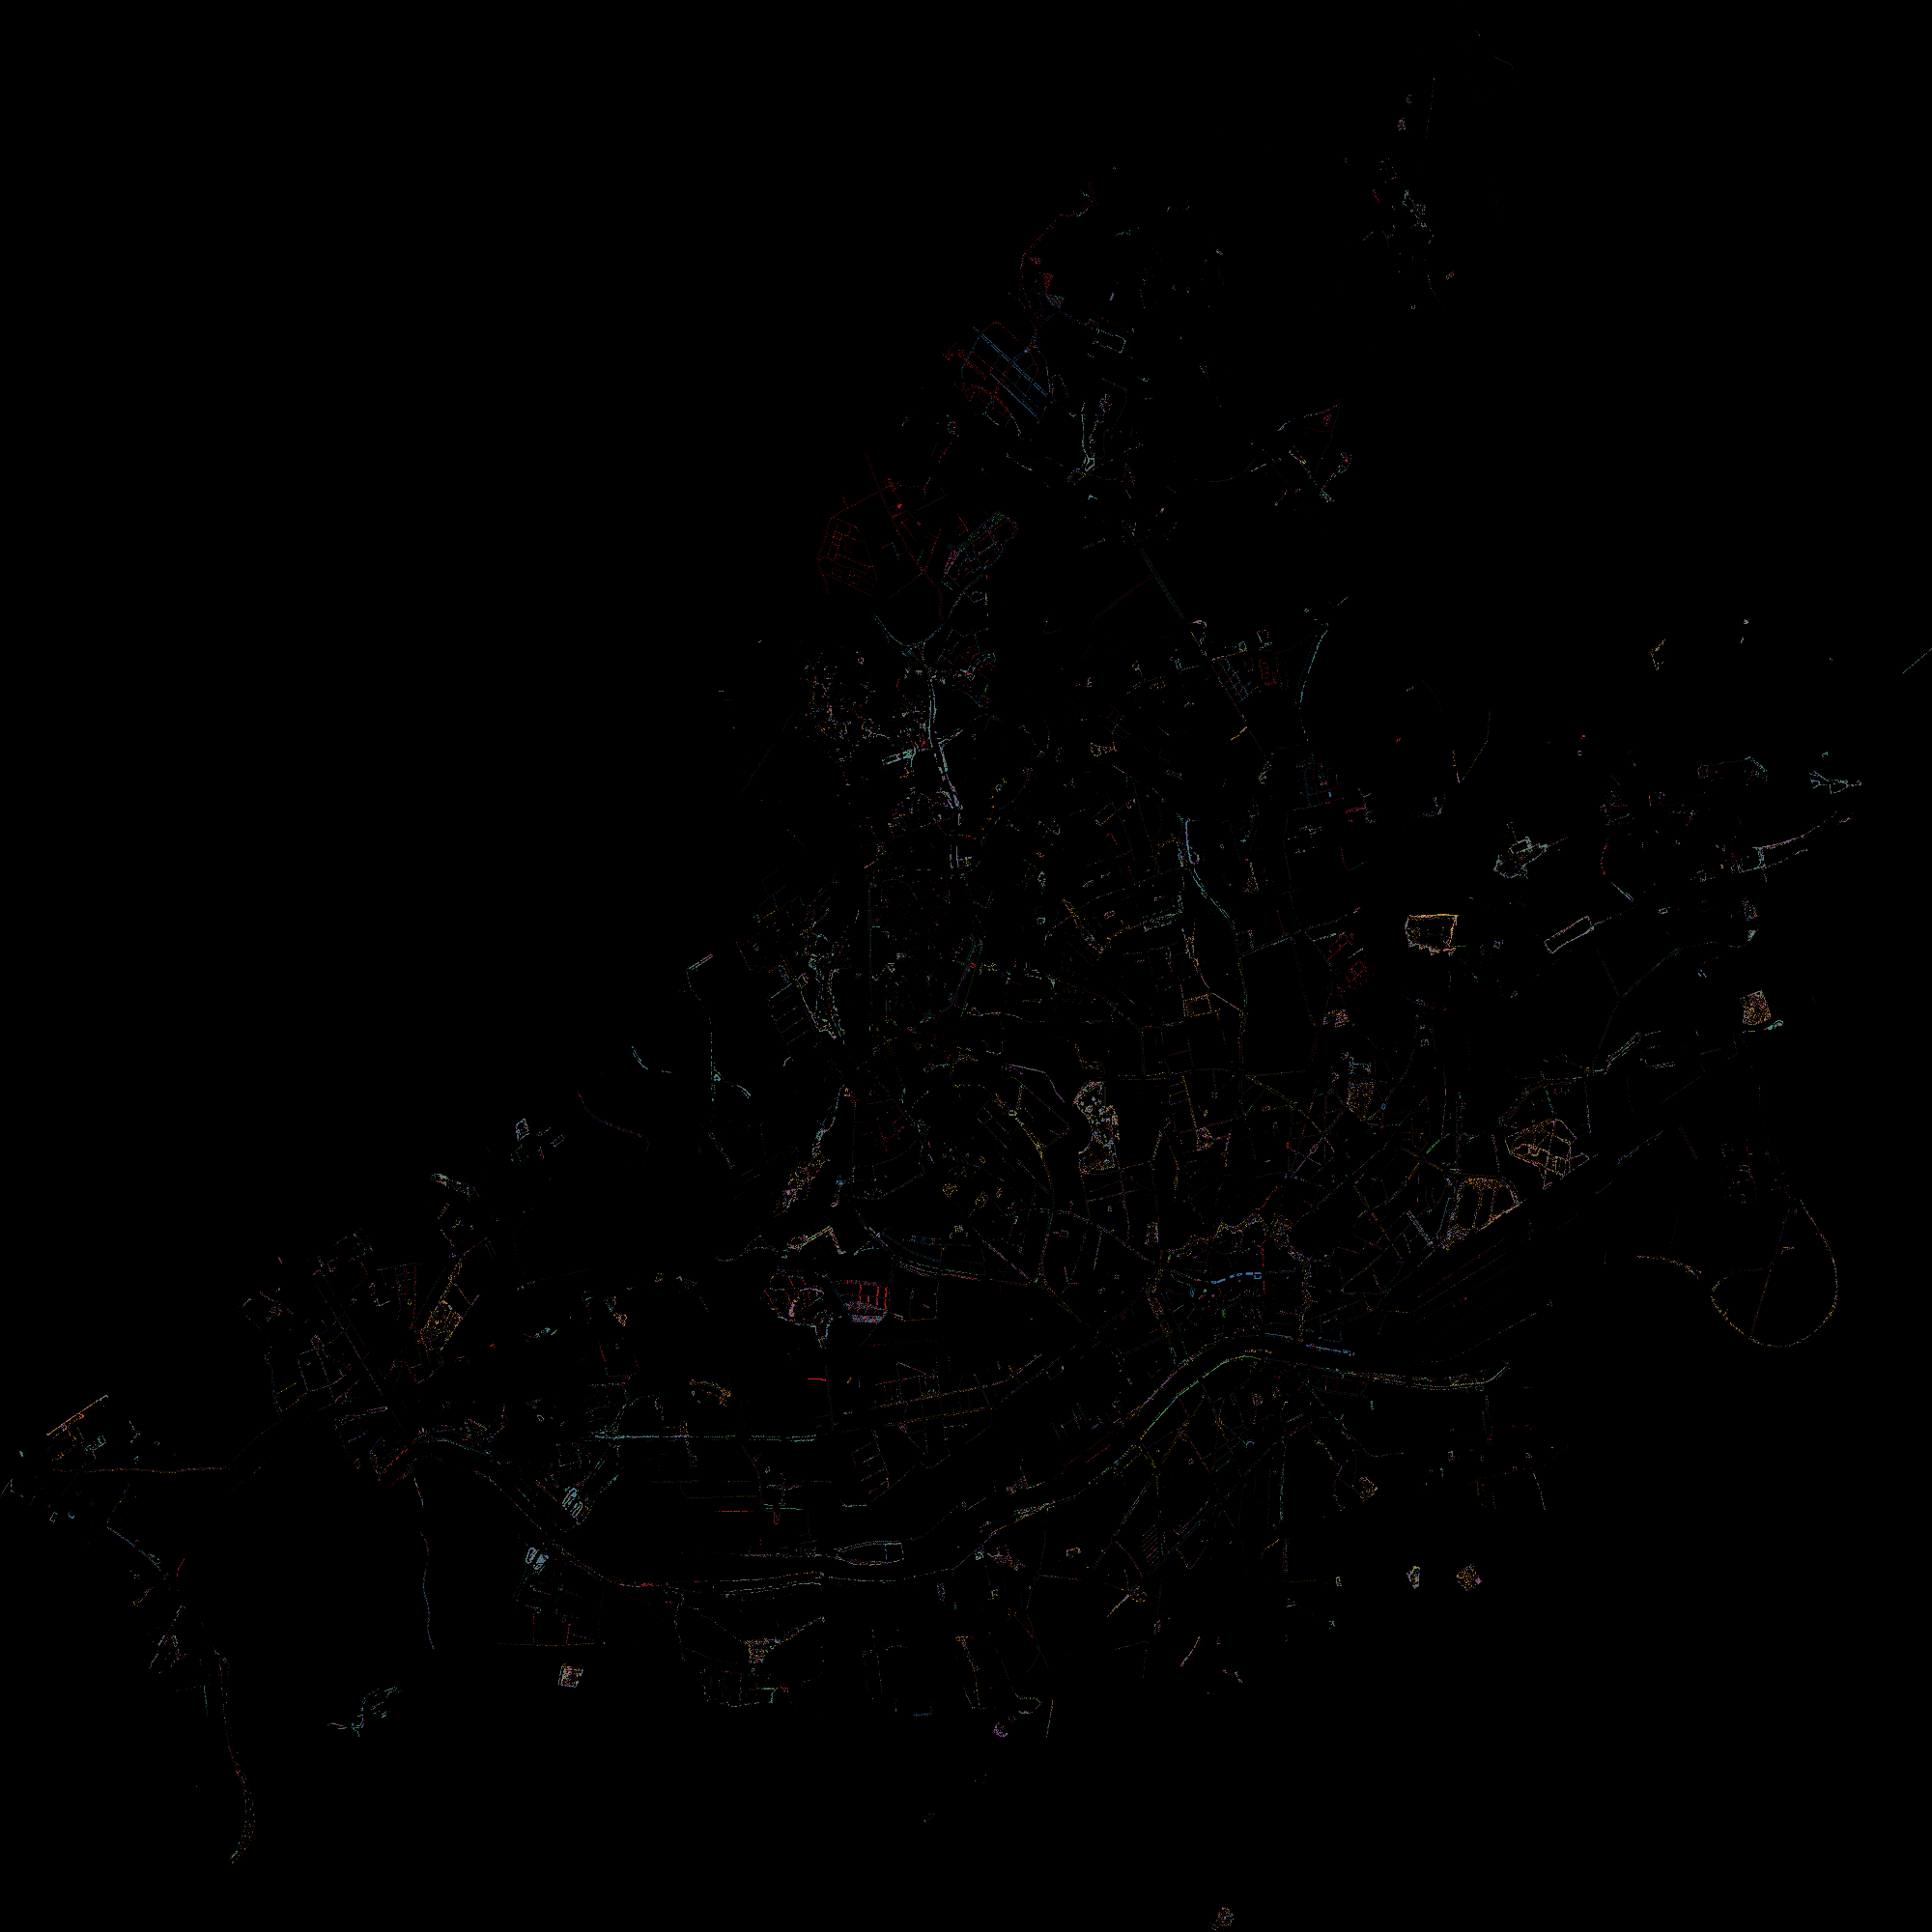

In [31]:
from colorcet import glasbey
cvs = ds.Canvas(plot_width, plot_height, *FFM)
agg = cvs.points(df, 'RECHTSWERT', 'HOCHWERT', ds.count_cat('diskret_kronendurchmesser'))
export(tf.shade(agg, cmap = cm(glasbey,0.4)), "Frankfurt_Baumbestand_Category")

In [49]:
legend_elements = list()

# Create legend for tree size colors 
labels = dict(
  zip(
    [
    'mini', 
    'klein', 
    'klein_2', 
    'mittel', 
    'mittel_2', 
    'mittel_3', 
    'groß', 
    'groß_2'],
  np.arange(8) ) )

for category, category_code in labels.items(): 
    element = Line2D(
    [0],
    [0],    
    marker='o',
    color='k',
    label=category,
    markerfacecolor=glasbey[category_code],
    markersize=10)
    
    # append legend entry to list of legend entries
    legend_elements.append(element)

#Create arbitrary plot
fig, ax = plt.subplots()
legend = ax.legend(handles=legend_elements, loc='center')

#Format the legend 
legend.get_frame().set_linewidth(1)
legend.get_frame().set_facecolor('k')
plt.setp(legend.get_texts(), color='w')

# save SVG of legend to file
plt.savefig('legend.png')
plt.close()

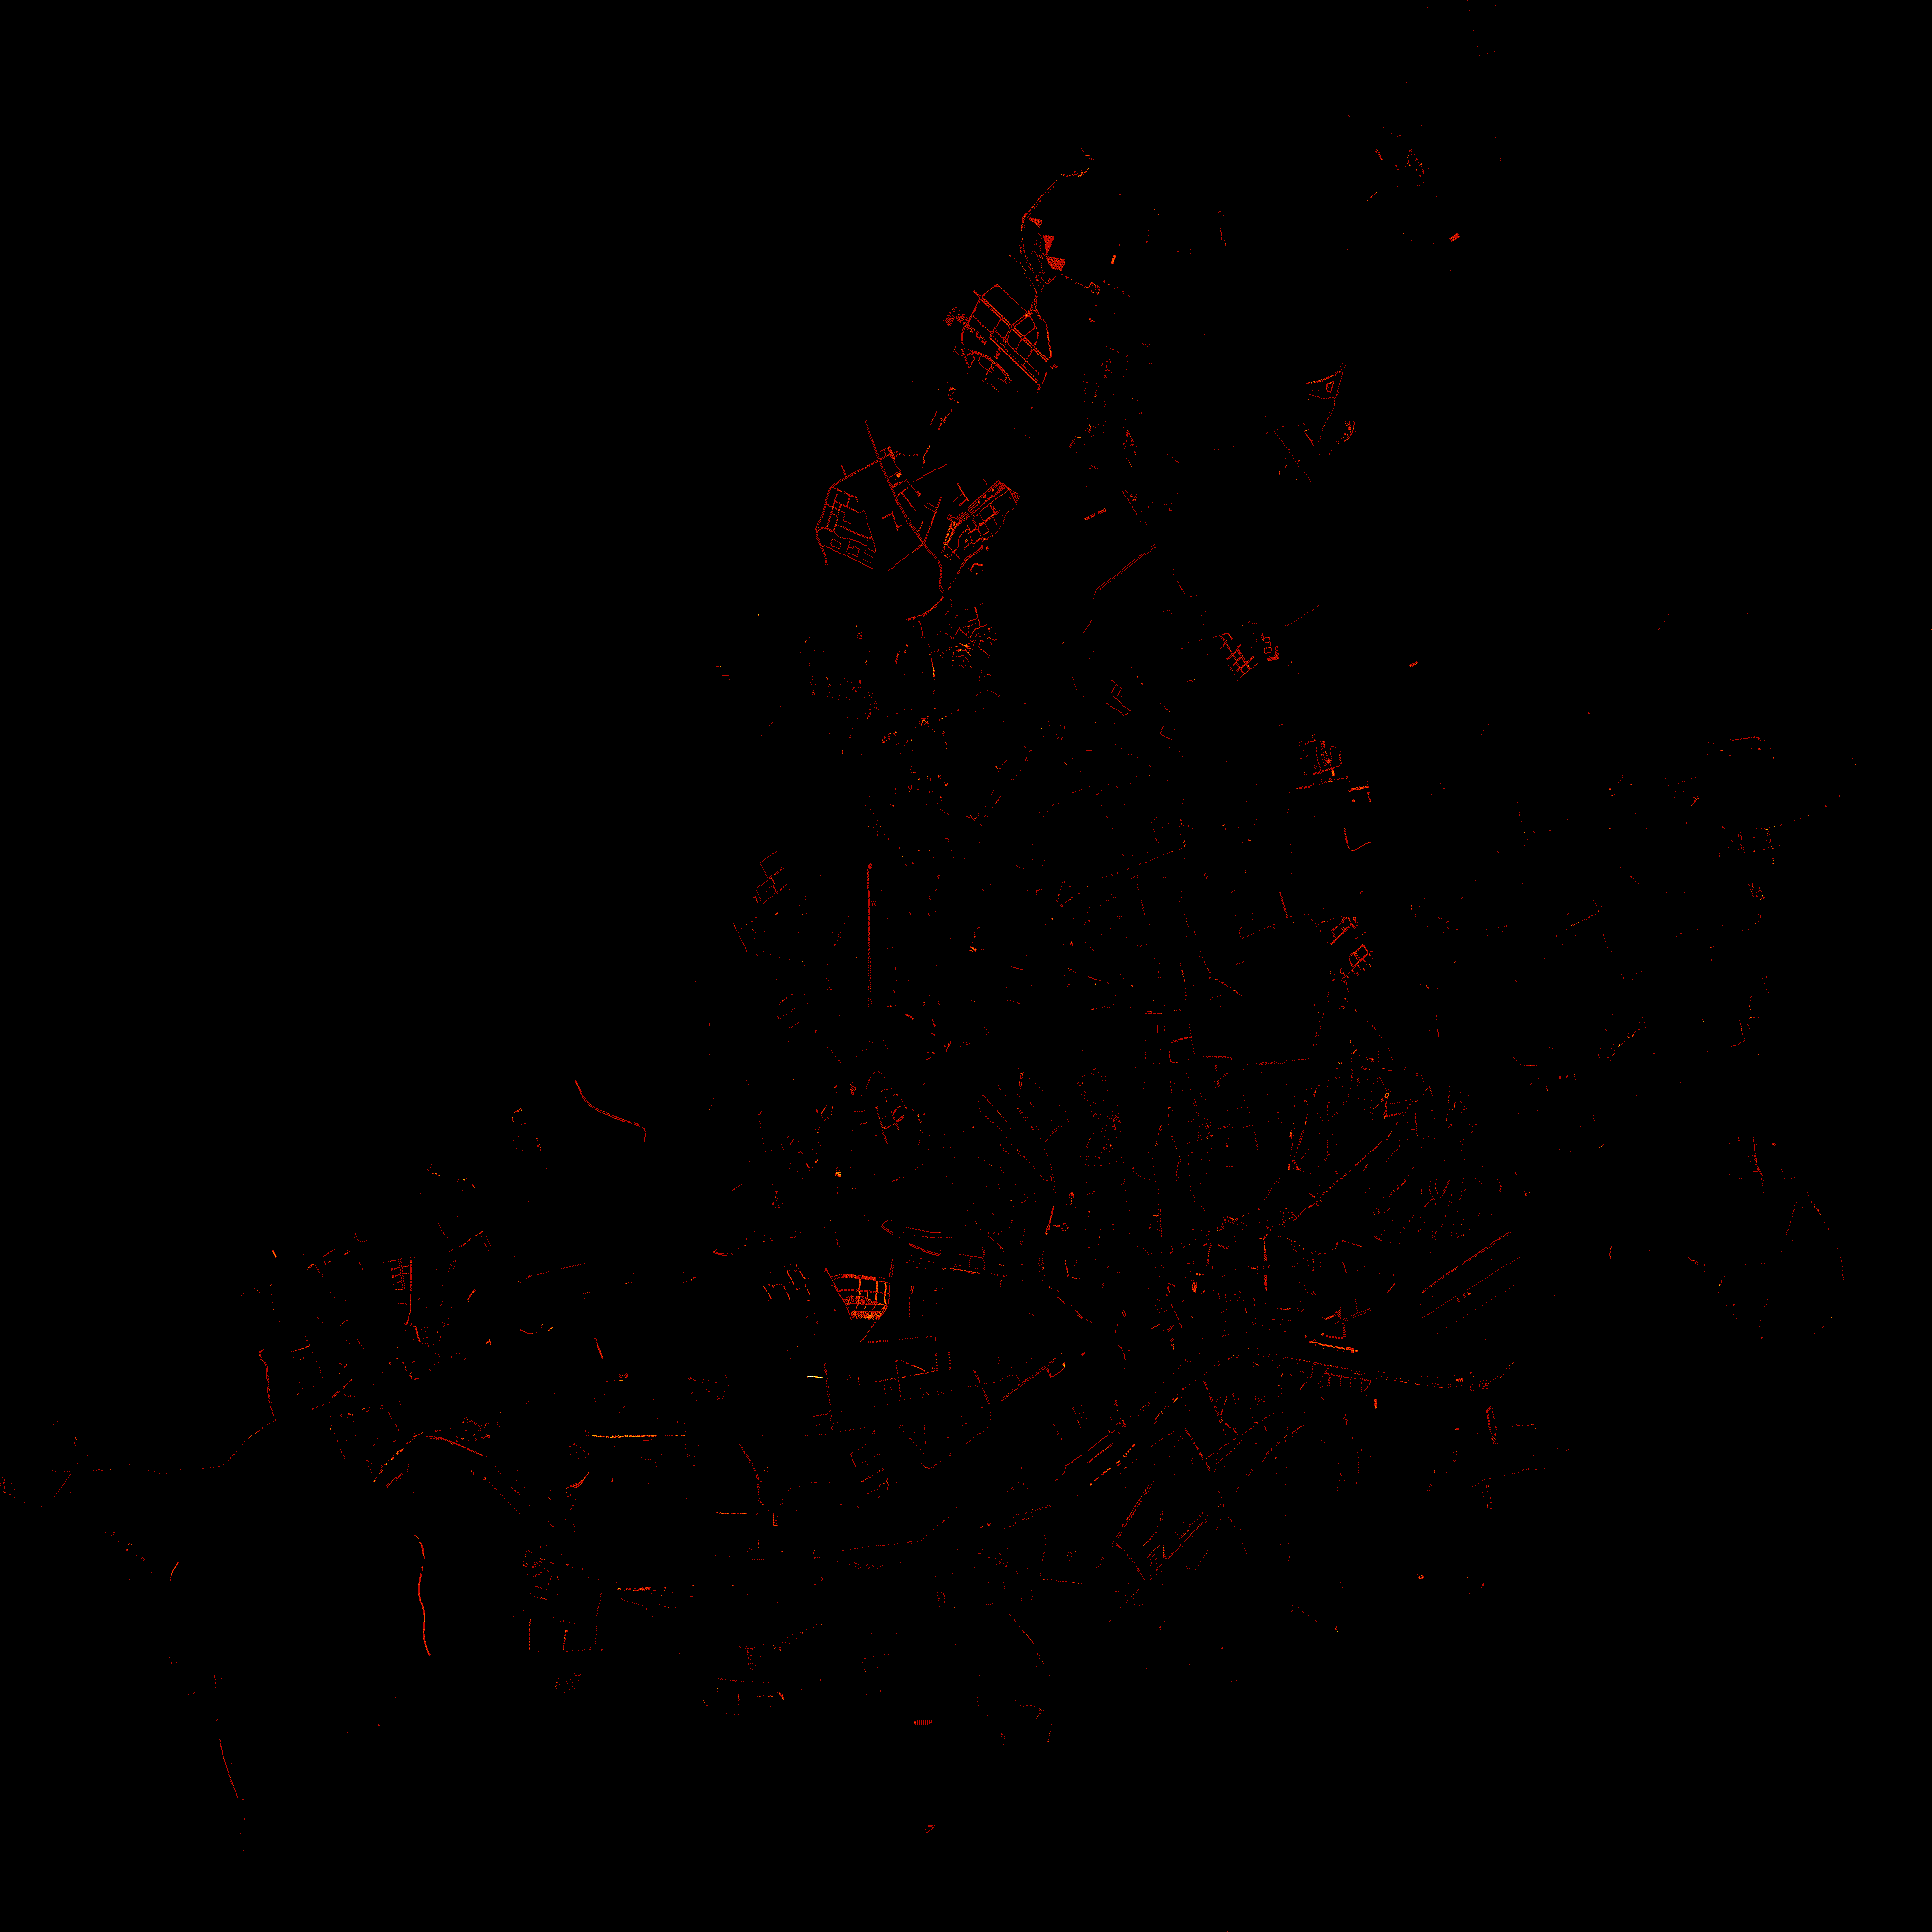

In [13]:
from colorcet import fire
y_range_min_new = new_df['lat'].quantile(0.01)
y_range_max_new = new_df['lat'].quantile(0.99)
x_range_min_new = new_df['lon'].quantile(0.01)
x_range_max_new = new_df['lon'].quantile(0.99)

sw_new = webm(x_range_min_new, y_range_min_new)
ne_new = webm(x_range_max_new, y_range_max_new)
FFM_new = zip(sw_new, ne_new)


plot_width = int(2000)
plot_height = int(2000)
background="black"
export = partial(export_image, background = background, export_path="export")
#cm = partial(colormap_select, reverse=(background!="black"))
cm = partial(colormap_select, reverse=(background!="black"))


display(HTML("<style>.container {width:100%} !important; }</style>"))

cvs = ds.Canvas(plot_width, plot_height, *FFM)
agg = cvs.points(new_df, 'RECHTSWERT', 'HOCHWERT')

export(tf.shade(agg, cmap = cm(fire,0.4), how='log'), "Frankfurt_Baumbestand_nach_2000")

In [12]:
from datashader.utils import lnglat_to_meters
df.loc[:, 'lon'], df.loc[:, 'lat'] = lnglat_to_meters(df.lon,df.lat)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
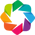

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [lon,lat]   (R,G,B,A)

In [13]:
import holoviews as hv
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
#from datashader.utils import lnglat_to_meters
hv.extension('bokeh')
from colorcet import fire

#df.loc[:, 'lon'], df.loc[:, 'lat'] = lnglat_to_meters(df.lon,df.lat)
map_tiles  = EsriImagery().opts(alpha=0.5, width=900, height=600, bgcolor='black')
points     = hv.Points(df, ['lon', 'lat'])
baum = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=900, height=480)
baum_map = map_tiles * baum

baum_map

In [20]:
import bokeh
hv.save(baum_map, 'frankfurter_baum.html', backend='bokeh')